samples: 100 batch_mse: 0.7156376126853684
samples: 200 batch_mse: 0.40224730629670985
samples: 300 batch_mse: 0.3203722831450582
samples: 400 batch_mse: 0.2539296806558464
samples: 500 batch_mse: 0.15449296495124465
samples: 600 batch_mse: 0.1291726335504405
samples: 700 batch_mse: 0.08997003205442797
samples: 800 batch_mse: 0.0812916617201053
samples: 900 batch_mse: 0.06352191303859078
samples: 1000 batch_mse: 0.04281728942310799
samples: 1100 batch_mse: 0.03242714341234401
samples: 1200 batch_mse: 0.024889823577781908
samples: 1300 batch_mse: 0.025256662578556955
samples: 1400 batch_mse: 0.020325919852503108
samples: 1500 batch_mse: 0.020642129308704005
samples: 1600 batch_mse: 0.022736291267004268
samples: 1700 batch_mse: 0.015097587340352952
samples: 1800 batch_mse: 0.018624072301060737
samples: 1900 batch_mse: 0.02260052686237725
samples: 2000 batch_mse: 0.017115213191961777
samples: 2100 batch_mse: 0.014995921478226377
samples: 2200 batch_mse: 0.016210557875538534
samples: 2300 

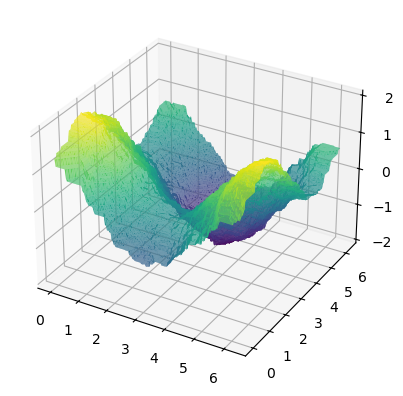

In [5]:
#!/usr/bin/env python
from __future__ import print_function
import numpy as np

class kanervacoder:
  def __init__(self, dims, ptypes, n_active, limits, dist=lambda x1, x2: np.max(np.abs(x1 - x2), axis=1), seed=None):
    np.random.seed(seed)
    self._n_pts = ptypes
    self._k = n_active
    self._lims = np.array(limits)
    self._ranges = self._lims[:, 1] - self._lims[:, 0]
    self._pts = np.random.random([self._n_pts, dims])
    self._dist = dist

  @property
  def n_ptypes(self):
    return self._n_pts
  
  def __getitem__(self, x):
    xs = (x - self._lims[:, 0]) / self._ranges
    return np.argpartition(self._dist(self._pts, xs), self._k)[:self._k]


def example():
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  import time

  # kanerva coder dimensions, limits, prototypes, number of active features
  dims = 2
  lims = [(0, 2.0 * np.pi)] * 2
  ptypes = 512
  n_active = 10

  # create kanerva coder
  K = kanervacoder(dims, ptypes, n_active, lims)

  # learning params
  w = np.zeros(K.n_ptypes)
  alpha = 0.1 / n_active

  # target function with gaussian noise
  def target_ftn(x, y, noise=True):
    return np.sin(x) + np.cos(y) + noise * np.random.randn() * 0.1

  # randomly sample target function until convergence
  timer = time.time()
  batch_size = 100
  for iters in range(100):
    mse = 0.0
    for b in range(batch_size):
      xi = lims[0][0] + np.random.random() * (lims[0][1] - lims[0][0])
      yi = lims[1][0] + np.random.random() * (lims[1][1] - lims[1][0])
      zi = target_ftn(xi, yi)
      phi = K[xi, yi]
      w[phi] += alpha * (zi - w[phi].sum())
      mse += (w[phi].sum() - zi) ** 2
    mse /= batch_size
    print('samples:', (iters + 1) * batch_size, 'batch_mse:', mse)
  print('elapsed time:', time.time() - timer)

  # get learned function
  print('mapping function...')
  res = 200
  x = np.arange(lims[0][0], lims[0][1], (lims[0][1] - lims[0][0]) / res)
  y = np.arange(lims[1][0], lims[1][1], (lims[1][1] - lims[1][0]) / res)
  z = np.zeros([len(y), len(x)])
  for i in range(len(x)):
    for j in range(len(y)):
      z[i, j] = w[K[x[i], y[j]]].sum()

  # plot
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  X, Y = np.meshgrid(x, y)
  ax.plot_trisurf(X.flatten(), Y.flatten(), z.flatten(), cmap=plt.cm.viridis, linewidth=0.2)
  plt.show()

if __name__ == '__main__':
  example()

In [2]:


# dimensions, value limits of each dimension, prototypes, and number of active features (k)
dims = 4
lims = [(3.0, 7.5), (-4.4, 4.2), (9.6, 12.7), (0.0, 1.0)]
ptypes = 1024
n_active = 32 

# create kanervacoder
K = kanervacoder(dims, ptypes, n_active, lims)

# init weights and step size
w = np.zeros(K.n_ptypes)
alpha = 0.1 / n_active

# training iteration with value 5.5 at location (3.3, -2.1, 11.1, 0.7)
phi = K[3.3, -2.1, 11.1, 0.7]
w[phi] = alpha * (5.5 - w[phi].sum())

# get approximated value at (3.3, -2.1, 11.1, 0.7)
print(w[phi].sum())

0.55


In [28]:
import numpy as np

class KanervaCoder:
    def __init__(self, dims, ptypes, n_active, limits=(0, 1), dist=lambda x1, x2: np.max(np.abs(x1 - x2), axis=1), seed=None):
        np.random.seed(seed)
        self._n_pts = ptypes
        self._k = n_active
        self._lims = np.array([limits] * dims)
        self._ranges = self._lims[:, 1] - self._lims[:, 0]
        self._pts = np.random.random([self._n_pts, dims])
        self._dist = dist

    def encode(self, state):
        state = np.clip(state, 0, 1)  # Ensure state values are between 0 and 1
        xs = (state - self._lims[:, 0]) / self._ranges
        indices = np.argpartition(self._dist(self._pts, xs), self._k)[:self._k]
        binary_repr = np.zeros(self._n_pts, dtype=int)
        binary_repr[indices] = 1
        return binary_repr.tolist()

def get_binary_representation(state):
    dims = 2
    ptypes = 10
    n_active = 4
    kc = KanervaCoder(dims, ptypes, n_active)
    return kc.encode(state)

# Example usage
state = np.array([ 0.3, 0.2])  # Example state
binary_representation = get_binary_representation(state)
print(binary_representation)


[0, 0, 0, 0, 1, 0, 0, 1, 1, 1]


In [16]:
decimal_state = 0
for i, bit in enumerate(reversed(binary_representation)):
    decimal_state += int(bit) * (2 ** i)
print(decimal_state)

168
